In [1]:
import EntropyHub as eh
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import antropy as ant
import neurokit2

In [2]:
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300

# Зчитування з Yahoo Finance

In [93]:
symbol = "XRP-USD"
symbol_for_graph = "XRP-USD"
data = yf.download(symbol, start="2016-01-01")
close = data['Adj Close'].copy()
for_graph = data['Adj Close'].copy()

np.savetxt(f'{symbol}_initial_time_series.txt', close.values)

[*********************100%***********************]  1 of 1 completed


In [94]:
close

Date
2017-11-09    0.217488
2017-11-10    0.206483
2017-11-11    0.210430
2017-11-12    0.197339
2017-11-13    0.203442
                ...   
2022-06-02    0.405302
2022-06-03    0.390766
2022-06-04    0.392309
2022-06-05    0.395380
2022-06-06    0.402990
Name: Adj Close, Length: 1671, dtype: float64

# Зчитування з .txt файлів

In [ ]:
symbol = "sMpa11.txt" #назва файлу 1, що зчитуємо

In [ ]:
with open(symbol, 'r') as f: #зчитуємо файл
    close = [line.strip('\n') for line in f.readlines()]
    close = [float(line) for line in close if line != '']
close = pd.Series(close) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

In [ ]:
symbol_for_graph = "Mpa11.txt" #для графіки

In [ ]:
with open(symbol_for_graph, 'r') as f_for_graph: #зчитуємо файл
    for_graph = [line.strip('\n') for line in f_for_graph.readlines()]
    for_graph = [float(line) for line in for_graph if line != '']
for_graph = pd.Series(for_graph) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

# Виведення графіку досліджуваного ряду

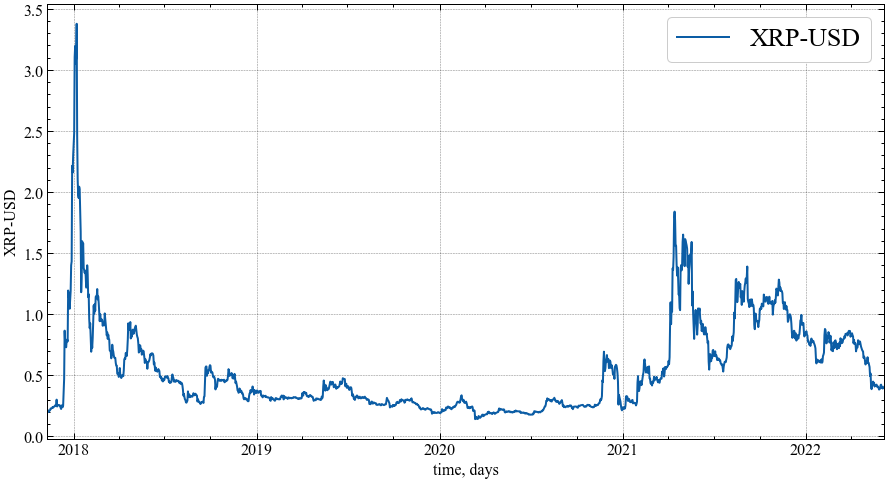

In [95]:
fig, ax = plt.subplots()
close.plot(figsize=(15,8), xlabel='time, days', ylabel=symbol)
ax.legend([symbol]);

plt.savefig(f'{symbol}.jpg')
plt.show()

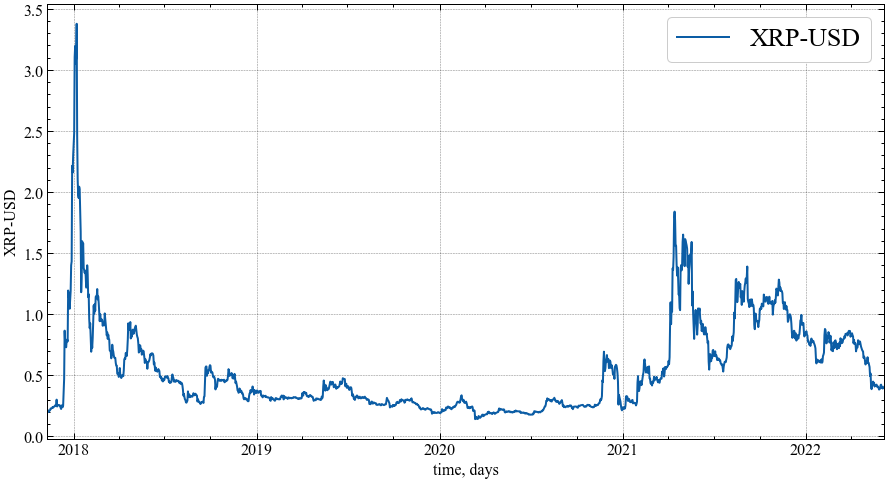

In [96]:
fig, ax = plt.subplots()
for_graph.plot(figsize=(15,8), xlabel='time, days', ylabel=symbol_for_graph)
ax.legend([symbol_for_graph]);

plt.savefig(f'{symbol_for_graph}.jpg')
plt.show()

# Задання ширини вікна та кроку

In [97]:
window = 100 #розмір вікна
tstep = 5 #крок вікна 

# Approximate entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
r = 0.4 #параметр подібності
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

ApEn = [] #масив для зберігання значень ентропії

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряд
    
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5:
        fragm = np.log(fragm) - np.log(fragm.shift(1))
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Ap, _ = eh.ApEn(Sig = fragm, m = m, tau = tau, r = r)
    ApEn.append(Ap[-1])

In [ ]:
name_for_save = f"ApEn_{symbol}_{window}_{tstep}_{m}_{tau}_{r}_{ret_type}.txt" #ім'я файлу для зберігання
with open(name_for_save, 'w') as f: #відкриваємо на запис 
    ApEn_file = [str(line) + '\n' for line in ApEn]
    f.writelines(ApEn_file)

In [ ]:
ApEn = np.asarray(ApEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
min_max_scaler = preprocessing.MinMaxScaler()
scaled_ApEn = min_max_scaler.fit_transform(ApEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(close.index[window:n:tstep], scaled_for_graph[window:n:tstep], label=f'{symbol_for_graph}')
ax.plot(close.index[window:n:tstep], scaled_ApEn, label='ApEn')
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, ApEn")
ax.set_title(f"ApEn, symbol={symbol}, window size={window}, time step={tstep}, embedding dimension={m}, delay={tau}, r={r}, seriestype={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"ApEn, symbol={symbol}, window size={window}, time step={tstep}, embedding dimension={m}, delay={tau}, r={r}, seriestype={ret_type}.jpg")
plt.show()

# Fuzzy entropy

In [98]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
characteristic_func = "default" #вид функції приналежності: default, sigmoid, gudermannian, linear
r1, r2 = 0.3, 2.0 #параметри, що подаються до функції приналежності. для default та sigmoid 2 значення r, 
                  #для gudermannian та linear 1 значення r  
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

FuzzEn = [] #масив для зберігання значень ентропії

In [99]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1: 
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5:
        fragm = np.log(fragm) - np.log(fragm.shift(1))
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Fuzz, _, _ = eh.FuzzEn(Sig = fragm, m = m, tau = tau, Fx = characteristic_func, r = (r1, r2)) #Рахуємо нечітку ентропію 
    FuzzEn.append(Fuzz[-1]) #дожаємо розрахованє значення до масиву значень 

In [100]:
name_for_save = f"FuzzEn_{symbol}_{window}_{tstep}_{m}_{tau}_{characteristic_func}_{r1}_{r2}_{ret_type}.txt" #ім'я файлу для зберігання
with open(name_for_save, 'w') as f: #відкриваємо на запис 
    FuzzEn_file = [str(line) + '\n' for line in FuzzEn]
    f.writelines(FuzzEn_file)

In [101]:
FuzzEn = np.asarray(FuzzEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
min_max_scaler = preprocessing.MinMaxScaler()
scaled_FuzzEn = min_max_scaler.fit_transform(FuzzEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

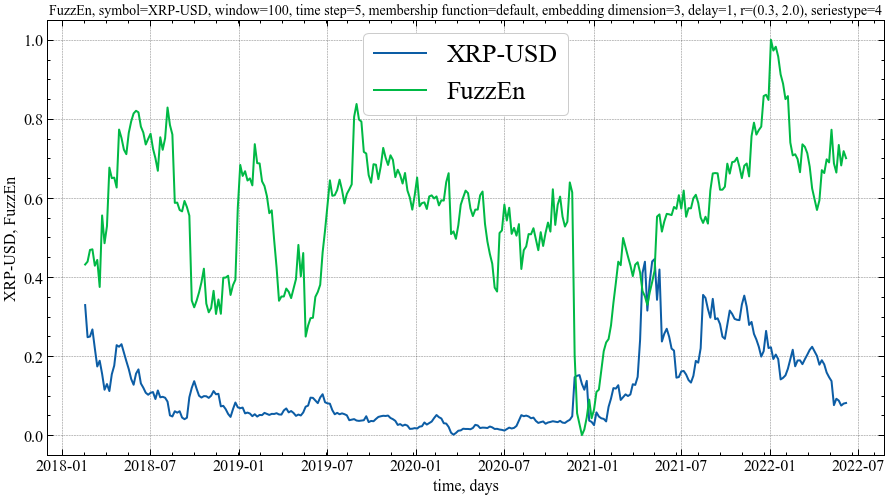

In [102]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(close.index[window:n:tstep], scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(close.index[window:n:tstep], scaled_FuzzEn, label="FuzzEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, FuzzEn")
ax.set_title(f"FuzzEn, symbol={symbol}, window={window}, time step={tstep}, membership function={characteristic_func}, embedding dimension={m}, delay={tau}, r={(r1, r2)}, seriestype={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"FuzzEn, symbol={symbol}, window={window}, time step={tstep}, membership function={characteristic_func}, embedding dimension={m}, delay={tau}, r={(r1, r2)}, seriestype={ret_type}.jpg")
plt.show()

# Sample entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
r = 0.4 #параметр подібності
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

SampEn = [] #масив для зберігання значень ентропії

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5:
        fragm = np.log(fragm) - np.log(fragm.shift(1))
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Samp, _, _ = eh.SampEn(Sig = fragm, m = m, tau = tau, r = r, Logx=np.exp(1))
    SampEn.append(Samp[-1])

In [ ]:
name_for_save = f"SampEn_{symbol}_{window}_{tstep}_{m}_{tau}_{r}_{ret_type}.txt" #ім'я файлу для зберігання
with open(name_for_save, 'w') as f: #відкриваємо на запис 
    SampEn_file = [str(line) + '\n' for line in SampEn]
    f.writelines(ApEn_file)

In [ ]:
SampEn = np.asarray(SampEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
min_max_scaler = preprocessing.MinMaxScaler()
scaled_SampEn = min_max_scaler.fit_transform(SampEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(close.index[window:n:tstep], scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(close.index[window:n:tstep], scaled_SampEn, label="SampEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, SampEn")
ax.set_title(f"SampEn, symbol={symbol}, window size={window}, time step={tstep}, embedding dimension={m}, delay={tau}, r={r}", fontsize=14)
ax.legend()

plt.savefig(f"SampEn, symbol={symbol}, window size={window}, time step={tstep}, embedding dimension={m}, delay={tau}, r={r}.jpg")
plt.show()

# Kolmogorov entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
r = 0.4 #параметр подібності
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

K2En = [] #масив для зберігання значень ентропії
Corr = [] #кореляційна сума

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    K2, Ci = eh.K2En(Sig = fragm, m = m, tau = tau, r = r * np.abs(np.std(fragm)))
    K2En.append(K2[-1])
    Corr.append(Ci[-1])

In [ ]:
K2En_for_save = f"KolmogorovEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_sigma={r}_seriestype={ret_type}.txt" #ім'я файлу для зберігання ентропії колмогорова
Ci_for_save = f"CorrSum_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_sigma={r}_seriestype={ret_type}.txt" #ім'я файлу для зберігання кореляційної суми
with open(K2En_for_save, 'w') as f: #відкриваємо на запис 
    K2En_file = [str(line) + '\n' for line in K2En]
    f.writelines(K2En_file)
    
with open(Ci_for_save, 'w') as f: #відкриваємо на запис 
    Ci_file = [str(line) + '\n' for line in Corr]
    f.writelines(Ci_file)

In [ ]:
K2En = np.asarray(K2En).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
Corr = np.asarray(Corr).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_K2En = min_max_scaler.fit_transform(K2En)
scaled_Corr = min_max_scaler.fit_transform(Corr)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(close.index[window:n:tstep], scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(close.index[window:n:tstep], scaled_K2En, label="K2En")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, K2En")
ax.set_title(f"K2En, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, sigma={r}, seriestype={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"K2En, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, sigma={r}, seriestype={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_Corr, label=r"$C(\epsilon)$")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}," + r"$C(\epsilon)$")
ax.set_title(f"Corr, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, sigma={r}, seriestype={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"Corr, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, sigma={r}, seriestype={ret_type}.jpg")
plt.show()

# Permutation entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
Type = 'none' # none - classic; 
              # finegrain - Fine-grained permutation entropy; 
              # modified - Modiﬁed permutation entropy; 
              # weighted - Weighted permutation entropy; 
              # ampaware - Amplitude-aware permutation entropy; 
              # edge - Edge permutation entropy; 
              # uniquant - Uniform quantization-based permutation entropy; 
            
tpx = -1 # finegrain tpx is the α parameter, a positive scalar (default: 1)
         # ampaware tpx is the A parameter, a value in range [0 1] (default: 0.5)
         # edge tpx is the r sensitivity parameter, a scalar > 0 (default: 1)
         # uniquant tpx is the L parameter, an integer > 1 (default: 4).

log = np.exp(1)
norm = True
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

PEn = [] #масив для зберігання значень нормалізованої перм. ентропії
CPEn = [] #масив для зберігання значень умовної перм. ентропії

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    _, Pnorm, cPE = eh.PermEn(fragm, m = m, tau = tau, Typex = Type, tpx = tpx, Logx = log, Norm = norm)
    PEn.append(Pnorm[-1])
    CPEn.append(cPE[-1])

In [ ]:
PEn_for_save = f"PEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_ret={ret_type}_type={Type}_param={tpx}.txt" #ім'я файлу для зберігання пермутаційної ентропії
CPEn_for_save = f"CPEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_ret={ret_type}_type={Type}_param={tpx}.txt" #ім'я файлу для зберігання умовної пермутаційної ентропії
with open(PEn_for_save, 'w') as f: #відкриваємо на запис 
    PEn_file = [str(line) + '\n' for line in PEn]
    f.writelines(PEn_file)
    
with open(CPEn_for_save, 'w') as f: #відкриваємо на запис 
    CPEn_file = [str(line) + '\n' for line in CPEn]
    f.writelines(CPEn_file)

In [ ]:
PEn = np.asarray(PEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
CPEn = np.asarray(CPEn).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_PEn = min_max_scaler.fit_transform(PEn)
scaled_CPEn = min_max_scaler.fit_transform(CPEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_PEn, label="PEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, PEn")
ax.set_title(f"PEn, symbol={symbol}, window={window}, step={tstep}, d={m}, tau={tau}, ret={ret_type}, type={Type}, param={tpx}", fontsize=14)
ax.legend()

plt.savefig(f"PEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_ret={ret_type}_type={Type}_param={tpx}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_CPEn, label="CPEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, CPEn")
ax.set_title(f"CPEn, symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_ret={ret_type}_type={Type}_param={tpx}", fontsize=14)
ax.legend()

plt.savefig(f"CPEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_ret={ret_type}_type={Type}_param={tpx}.jpg")
plt.show()

#  _Corrected_ Conditional entropy and Shannon entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
c = 6 # Number of symbols in symbolic transformation
norm = True
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб. 3-відносні приб. 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

CondEn = [] #масив значень для зберігання умовної ентропії 
ShEn = [] #масив значень для зберігання Шенонівської ентропії

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Cond, SE, _ = eh.CondEn(fragm, m = m, tau = tau, c = c, Norm = norm)
    CondEn.append(Cond[-1])
    ShEn.append(SE[-1])
    

In [ ]:
CondEn_for_save = f"CondEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_c={c}.txt" #ім'я файлу для зберігання умовної ентропії
ShEn_for_save = f"ShEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_c={c}.txt" #ім'я файлу для зберігання шенонівської ентропії
with open(CondEn_for_save, 'w') as f: #відкриваємо на запис 
    CondEn_file = [str(line) + '\n' for line in CondEn]
    f.writelines(CondEn_file)
    
with open(ShEn_for_save, 'w') as f: #відкриваємо на запис 
    ShEn_file = [str(line) + '\n' for line in ShEn]
    f.writelines(ShEn_file)

In [ ]:
CondEn = np.asarray(CondEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
ShEn = np.asarray(ShEn).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_CondEn = min_max_scaler.fit_transform(CondEn)
scaled_ShEn = min_max_scaler.fit_transform(ShEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_CondEn, label="CondEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, CondEn")
ax.set_title(f"CondEn, symbol={symbol}, window={window}, step={tstep}, d={m}, tau={tau}, series_type={ret_type}, c={c}", fontsize=14)
ax.legend()

plt.savefig(f"CondEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_c={c}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_ShEn, label="ShEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, ShEn")
ax.set_title(f"ShEn, symbol={symbol}, window={window}, step={tstep}, d={m}, tau={tau}, series_type={ret_type}, c={c}", fontsize=14)
ax.legend()

plt.savefig(f"ShEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_c={c}.jpg")
plt.show()

# Distribution entropy

In [ ]:
m = 3 #розмірність вкладень
tau = 1 #часова затримка
bins = 'sturges' # Метод визначення бінів гістограми. Окрім цього можна обрати sqrt, rice, doanes
norm = True
log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

DistEn = [] #масив значень для зберігання розподіленої ентропії 

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Dist = eh.DistEn(fragm, m = m, tau = tau, Bins = bins, Logx = log, Norm = norm)
    DistEn.append(Dist[0])

In [ ]:
DistEn_for_save = f"DistEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_bins={bins}.txt" #ім'я файлу для зберігання розподіленої ентропії
with open(DistEn_for_save, 'w') as f: #відкриваємо на запис 
    DistEn_file = [str(line) + '\n' for line in DistEn]
    f.writelines(DistEn_file)

In [ ]:
DistEn = np.asarray(DistEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()
scaled_DistEn = min_max_scaler.fit_transform(DistEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_DistEn, label="DistEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, DistEn")
ax.set_title(f"DistEn, symbol={symbol}, window={window}, step={tstep}, d={m}, tau={tau}, series_type={ret_type}, bins={bins}", fontsize=14)
ax.legend()

plt.savefig(f"DistEn_symbol={symbol}_window={window}_step={tstep}_d={m}_tau={tau}_series_type={ret_type}_bins={bins}.jpg")
plt.show()

# Spectral entropy

In [ ]:
norm = True # Normalization of Spec value:
            # false no normalisation
            # true normalises Spec w.r.t number of Nyquist frequency value, and SpecBandEn
            # w.r.t. range of frequencies in the band given by Freqs. (default)

freq = (0.2, 0.8) # Normalised band edge-frequencies for calculating the band entropy (BandEn), a 2
                  # element tuple with values in range [0,1] where 1 is the Nyquist frequency
    
res = 2 * window + 1 # Resolution of the N-point fft, an integer > 1.
log = np.exp(1) 
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

SpecEn = [] #масив значень для зберігання спектральної ентропії 
SpecBandEn = [] 

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Spec, Band = eh.SpecEn(fragm, N = res, Freqs = freq, Norm = norm, Logx = log)
    SpecEn.append(Spec)
    SpecBandEn.append(Band)

In [ ]:
SpecEn_for_save = f"SpecEn_symbol={symbol}_window={window}_step={tstep}_freq={freq}_res={res}_series_type={ret_type}.txt" #ім'я файлу для зберігання SpecEn
SpecBandEn_for_save = f"SpecBandEn_symbol={symbol}_window={window}_step={tstep}_freq={freq}_res={res}_series_type={ret_type}.txt" #ім'я файлу для зберігання SpecBandEn
with open(SpecEn_for_save, 'w') as f: #відкриваємо на запис 
    SpecEn_file = [str(line) + '\n' for line in SpecEn]
    f.writelines(SpecEn_file)
    
with open(SpecBandEn_for_save, 'w') as f: #відкриваємо на запис 
    SpecBandEn_file = [str(line) + '\n' for line in SpecBandEn]
    f.writelines(SpecBandEn_file)

In [ ]:
SpecEn = np.asarray(SpecEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
SpecBandEn = np.asarray(SpecBandEn).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_SpecEn = min_max_scaler.fit_transform(SpecEn)
scaled_SpecBandEn = min_max_scaler.fit_transform(SpecBandEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_SpecEn, label="SpecEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, SpecEn")
ax.set_title(f"SpecEn, symbol={symbol}, window={window}, step={tstep}, freq={freq}, res={res}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"SpecEn_symbol={symbol}_window={window}_step={tstep}_freq={freq}_res={res}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_SpecBandEn, label="SpecBandEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, SpecEn")
ax.set_title(f"SpecBandEn, symbol={symbol}, window={window}, step={tstep}, freq={freq}, res={res}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"SpecBandEn_symbol={symbol}_window={window}_step={tstep}_freq={freq}_res={res}_series_type={ret_type}.jpg")
plt.show()

# Dispersion entropy

In [ ]:
norm = True
fluct = False # Якщо True повертаємо флуктуаційно-дисперсійну ентропію
m = 3 
tau = 1
rho = 1 # *If Typex = "finesort", rho is the tuning parameter, a positive scalar (default:1)

classes = 3 # кількість символів, що задіяні при перетворені
Type = 'ncdf' # тип символьного перетворення. "ncdf" Normalised cumulative distribution function [19]
                                            # "kmeans" K-means clustering algorithm. Note: The ”kmeans” algorithm uses random initialization conditions. This causes results to vary slightly each time it is called.
                                            # "linear" Linear segmentation of signal range
                                            # "finesort" Fine-sorted dispersion entropy
                                            # "equal" Approx. equal number of symbols.

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

DispEn = [] # масив значень для зберігання дисперсійної ентропії 
RevDispEn = [] # для зберігання оборотної дисперсійної ентропії

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Disp, RevDisp = eh.DispEn(fragm, m = m, tau = tau, c = classes, Typex = Type, 
                              Logx = log, Fluct = fluct, Norm = norm, rho = rho)
    DispEn.append(Disp)
    RevDispEn.append(RevDisp)

In [ ]:
DispEn_for_save = f"DispEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_fluct={fluct}_rho={rho}_classes={classes}_type={Type}.txt" #ім'я файлу для зберігання DispEn
RevDispEn_for_save = f"RevDispEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_fluct={fluct}_rho={rho}_classes={classes}_type={Type}.txt" #ім'я файлу для зберігання RevDispEn
with open(DispEn_for_save, 'w') as f: #відкриваємо на запис 
    DispEn_file = [str(line) + '\n' for line in DispEn]
    f.writelines(DispEn_file)
    
with open(RevDispEn_for_save, 'w') as f: #відкриваємо на запис 
    RevDispEn_file = [str(line) + '\n' for line in RevDispEn]
    f.writelines(RevDispEn_file)

In [ ]:
DispEn = np.asarray(DispEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
RevDispEn = np.asarray(RevDispEn).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_DispEn = min_max_scaler.fit_transform(DispEn)
scaled_RevDispEn = min_max_scaler.fit_transform(RevDispEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_DispEn, label="DispEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, DispEn")
ax.set_title(f"DispEn, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, series_type={ret_type}, fluct={fluct}, rho={rho}, classes={classes}, type={Type}", fontsize=14)
ax.legend()

plt.savefig(f"DispEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_fluct={fluct}_rho={rho}_classes={classes}_type={Type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_RevDispEn, label="RevDispEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, RevDispEn")
ax.set_title(f"RevDispEn, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, series_type={ret_type}, fluct={fluct}, rho={rho}, classes={classes}, type={Type}", fontsize=14)
ax.legend()

plt.savefig(f"RevDispEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_fluct={fluct}_rho={rho}_classes={classes}_type={Type}.jpg")
plt.show()

# Symbolic Dynamic Entropy


In [ ]:
norm = True
m = 3 
tau = 1
c = 6 # Number of symbols, an integer > 1.

Type = 'linear' # Type of symbolic sequence partitioning, one of the following strings: 
             # "MEP" Maximum entropy partitioning [24]
             # "kmeans" K-means clustering algorithm. Note: The ”kmeans” algorithm uses random initialization conditions. This causes results to vary slightly when repeatedly called.
             # "linear" Linear segmentation of signal range
             # "uniform" Approx. equal number of symbols.

log = np.exp(1)
ret_type = 1 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

SyDyEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    SyDy, _ = eh.SyDyEn(fragm, m = m, tau = tau, c = c, Typex = Type, Logx = log, Norm = norm)
    SyDyEn.append(SyDy)

In [ ]:
SyDyEn_for_save = f"SyDyEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_type={Type}_c={c}.txt"
with open(SyDyEn_for_save, 'w') as f: #відкриваємо на запис 
    SyDyEn_file = [str(line) + '\n' for line in SyDyEn]
    f.writelines(SyDyEn_file)


In [ ]:
SyDyEn = np.asarray(SyDyEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()

scaled_SyDyEn = min_max_scaler.fit_transform(SyDyEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_SyDyEn, label="SyDyEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, SyDyEn")
ax.set_title(f"SyDyEn, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, series_type={ret_type}, type={Type}, c={c}", fontsize=14)
ax.legend()

plt.savefig(f"SyDyEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_type={Type}_c={c}.jpg")
plt.show()

# Increment entropy

In [ ]:
norm = True
m = 3 
tau = 1
r = 4 # Quantifying resolution, a positive scalar.

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

IncEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Incr = eh.IncrEn(fragm, m = m, tau = tau, R = r, Logx = log, Norm = norm)
    IncEn.append(Incr)

In [ ]:
IncrEn_for_save = f"IncrEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_res={r}.txt"
with open(IncrEn_for_save, 'w') as f: #відкриваємо на запис 
    IncEn_file = [str(line) + '\n' for line in IncEn]
    f.writelines(IncEn_file)

In [ ]:
IncrEn = np.asarray(IncEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()

scaled_IncrEn = min_max_scaler.fit_transform(IncrEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_IncrEn, label="IncEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, IncEn")
ax.set_title(f"IncrEn, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, series_type={ret_type}, res={r}", fontsize=14)
ax.legend()

plt.savefig(f"IncrEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_res={r}.jpg")
plt.show()

# Cosine similarity entropy

In [ ]:
m = 3 
tau = 1
r = 0.1 # Angular threshold, a value in range [0 < r < 1]
norm = 3 # Normalisation of Sig, an interger in range [0 4]:
         # 0 - no normalisation (default)
         # 1 - median removed
         # 2 - mean removed
         # 3 - normalised by standard deviation
         # 4 - normalised to range [-1 1]

log = np.exp(1)
ret_type = 1 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

CoSiEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    CoSi, _ = eh.CoSiEn(fragm, m = m, tau = tau, r = r, Logx = log, Norm = norm)
    CoSiEn.append(CoSi)

In [ ]:
CoSiEn_for_save = f"CoSiEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_res={r}_Norm={norm}.txt"
with open(CoSiEn_for_save, 'w') as f: #відкриваємо на запис 
    CoSiEn_file = [str(line) + '\n' for line in CoSiEn]
    f.writelines(CoSiEn_file)

In [ ]:
CoSiEn = np.asarray(CoSiEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()

scaled_CoSiEn = min_max_scaler.fit_transform(CoSiEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_CoSiEn, label="CoSiEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, CoSiEn")
ax.set_title(f"CoSiEn, symbol={symbol}, window={window}, step={tstep}, d_e={m}, tau={tau}, series_type={ret_type}, res={r}, Norm={norm}", fontsize=14)
ax.legend()

plt.savefig(f"CoSiEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_res={r}_Norm={norm}.jpg")
plt.show()

# Phase entropy

In [ ]:
tau = 1
k = 4 # Number of angular partitions, an integer > 1.
      # Note: Angular partitions of the second-order difference plot (SODP) are ﬁrst split
      # between 0 and n degrees w.r.t. the positive x-axis.
        
norm = True

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

PhaseEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Phas = eh.PhasEn(fragm, tau = tau, K = k, Logx = log, Norm = norm)
    PhaseEn.append(Phas)

In [ ]:
PhaseEn_for_save = f"PhaseEn_symbol={symbol}_window={window}_step={tstep}_tau={tau}_series_type={ret_type}_K={k}.txt"
with open(PhaseEn_for_save, 'w') as f: #відкриваємо на запис 
    PhaseEn_file = [str(line) + '\n' for line in PhaseEn]
    f.writelines(PhaseEn_file)

In [ ]:
PhaseEn = np.asarray(PhaseEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()

scaled_PhaseEn = min_max_scaler.fit_transform(PhaseEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_PhaseEn, label="PhasEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, PhaseEn")
ax.set_title(f"PhasEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}, K={k}", fontsize=14)
ax.legend()

plt.savefig(f"PhaseEn_symbol={symbol}_window={window}_step={tstep}_tau={tau}_series_type={ret_type}_K={k}.jpg")
plt.show()

# Slope entropy

In [ ]:
tau = 1
lvls = (5, 45) # Angular thresolds, a vector (or tuple in python) of monotonically increasing values in the range [0 90] degrees

m = 3
        
norm = True

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

SlopEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Slop = eh.SlopEn(fragm, m = m, tau = tau, Lvls = lvls, Logx = log, Norm = norm)
    SlopEn.append(Slop[-1])

In [ ]:
SlopEn_for_save = f"SlopEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_lvls={lvls}.txt"
with open(SlopEn_for_save, 'w') as f: #відкриваємо на запис 
    SlopEn_file = [str(line) + '\n' for line in SlopEn]
    f.writelines(SlopEn_file)

In [ ]:
SlopEn = np.asarray(SlopEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації

min_max_scaler = preprocessing.MinMaxScaler()

scaled_SlopEn = min_max_scaler.fit_transform(SlopEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_SlopEn, label="SlopEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, SlopEn")
ax.set_title(f"SlopEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}, lvls={lvls}", fontsize=14)
ax.legend()

plt.savefig(f"SlopEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}_lvls={lvls}.jpg")
plt.show()

# Bubble entropy and Conditional Renyi entropy

In [ ]:
m = 4
tau = 1
        
norm = True

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

BubbEn = []
CondRenEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Bubb, H = eh.BubbEn(fragm, m = m, tau = tau, Logx = log)
    BubbEn.append(Bubb[-1])
    CondRenEn.append(H[-1])

In [ ]:
BubbEn_for_save = f"BubbEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.txt"
with open(BubbEn_for_save, 'w') as f: #відкриваємо на запис 
    BubbEn_file = [str(line) + '\n' for line in BubbEn]
    f.writelines(BubbEn_file)
    
CondRenEn_for_save = f"CondRenEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.txt"
with open(CondRenEn_for_save, 'w') as f: #відкриваємо на запис 
    CondRenEn_file = [str(line) + '\n' for line in CondRenEn]
    f.writelines(CondRenEn_file)

In [ ]:
BubbEn = np.asarray(BubbEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
CondRenEn = np.asarray(CondRenEn).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()

scaled_BubbEn = min_max_scaler.fit_transform(BubbEn)
scaled_CondRenEn = min_max_scaler.fit_transform(CondRenEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_BubbEn, label="BubbEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, BubbEn")
ax.set_title(f"BubbEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"BubbEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_CondRenEn, label="CondRenEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, CondRenEn")
ax.set_title(f"CondRenEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"CondRenEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.jpg")
plt.show()

# Gridded distribution entropy and Gridded distribution rate

In [ ]:
m = 4
tau = 1

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

GDEn = []
GDRate = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    GDE, GDR, _, = eh.GridEn(fragm, m = m, tau = tau, Logx = log)
    GDEn.append(GDE)
    GDRate.append(GDR)

In [ ]:
GDEn_for_save = f"GDEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.txt"
with open(GDEn_for_save, 'w') as f: #відкриваємо на запис 
    GDEn_file = [str(line) + '\n' for line in GDEn]
    f.writelines(GDEn_file)
    
GDRate_for_save = f"GDRate_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.txt"
with open(GDRate_for_save, 'w') as f: #відкриваємо на запис 
    GDRate_file = [str(line) + '\n' for line in GDRate]
    f.writelines(GDRate_file)

In [ ]:
GDEn = np.asarray(GDEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
GDRate = np.asarray(GDRate).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()

scaled_GDEn = min_max_scaler.fit_transform(GDEn)
scaled_GDRate = min_max_scaler.fit_transform(GDRate)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_GDEn, label="GDEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, GDEn")
ax.set_title(f"GDEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"GDEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_GDRate, label="GDRate")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, GDRate")
ax.set_title(f"GDRate, symbol={symbol}, window={window}, step={tstep}, tau={tau}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"GDRate_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_series_type={ret_type}.jpg")
plt.show()

# Entropy of entropy

In [ ]:
tau = 2
s = (10, 5) # Number of slices (s1,s2), a two-element tuple of integers > 2

log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

EnoEn = []
AvgEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    EoE, Avg = eh.EnofEn(fragm, tau = tau, S = s, Logx = log)

    EnoEn.append(EoE)
    AvgEn.append(Avg)

In [ ]:
EnoEn_for_save = f"EnoEn_symbol={symbol}_window={window}_step={tstep}_tau={tau}_S={s}_series_type={ret_type}.txt"
with open(EnoEn_for_save, 'w') as f: #відкриваємо на запис 
    EnoEn_file = [str(line) + '\n' for line in EnoEn]
    f.writelines(EnoEn_file)
    
AvgEn_for_save = f"AvgEn_symbol={symbol}_window={window}_step={tstep}_tau={tau}_S={s}_series_type={ret_type}.txt"
with open(AvgEn_for_save, 'w') as f: #відкриваємо на запис 
    AvgEn_file = [str(line) + '\n' for line in AvgEn]
    f.writelines(AvgEn_file)

In [ ]:
EnoEn = np.asarray(EnoEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
AvgEn = np.asarray(AvgEn).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()

scaled_EnoEn = min_max_scaler.fit_transform(EnoEn)
scaled_AvgEn = min_max_scaler.fit_transform(AvgEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_EnoEn, label="EnoEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, EnoEn")
ax.set_title(f"EnoEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, S={s}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"EnoEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_S={s}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_AvgEn, label="AvgEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, AvgEn")
ax.set_title(f"AvgEn, symbol={symbol}, window={window}, step={tstep}, tau={tau}, S={s}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"AvgEn_symbol={symbol}_window={window}_step={tstep}_d_e={m}_tau={tau}_S={s}_series_type={ret_type}.jpg")
plt.show()

# Attention entropy
# Entropy of local-maxima intervals 
# Entropy of local-minima intervals 
# Entropy of intervals between local maxima and subsequent minima
# Entropy of intervals between local minima and subsequent maxima

In [ ]:
log = np.exp(1)
ret_type = 4 #вид ряду: 1-вихідний, 2-абсолютні приб., 3-відносні приб., 4-нормалізовані приб. 
n = close.shape[0] #задаємо кількість значень

AttnEn = []
HxxEn = []
HnnEn = []
HxnEn = []
HnxEn = []

In [ ]:
for i in range(0,n-window,tstep):
    fragm = close.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    Attn, H = eh.AttnEn(fragm, Logx = log)

    AttnEn.append(Attn)
    HxxEn.append(H[0])
    HnnEn.append(H[1])
    HxnEn.append(H[2])
    HnxEn.append(H[3])

In [ ]:
AttnEn_for_save = f"AttnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.txt"
with open(AttnEn_for_save, 'w') as f: #відкриваємо на запис 
    AttnEn_file = [str(line) + '\n' for line in AttnEn]
    f.writelines(AttnEn_file)
    
HxxEn_for_save = f"HxxEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.txt"
with open(HxxEn_for_save, 'w') as f: #відкриваємо на запис 
    HxxEn_file = [str(line) + '\n' for line in HxxEn]
    f.writelines(HxxEn_file)
    
HnnEn_for_save = f"HnnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.txt"
with open(HnnEn_for_save, 'w') as f: #відкриваємо на запис 
    HnnEn_file = [str(line) + '\n' for line in HnnEn]
    f.writelines(HnnEn_file)
    
HxnEn_for_save = f"HxnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.txt"
with open(HxnEn_for_save, 'w') as f: #відкриваємо на запис 
    HxnEn_file = [str(line) + '\n' for line in HxnEn]
    f.writelines(HxnEn_file)
    
HnxEn_for_save = f"HnxEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.txt"
with open(HnxEn_for_save, 'w') as f: #відкриваємо на запис 
    HnxEn_file = [str(line) + '\n' for line in HnxEn]
    f.writelines(HnxEn_file)

In [ ]:
AttnEn = np.asarray(AttnEn).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
HxxEn = np.asarray(HxxEn).reshape(-1, 1)
HnnEn = np.asarray(HnnEn).reshape(-1, 1)
HxnEn = np.asarray(HxnEn).reshape(-1, 1)
HnxEn = np.asarray(HnxEn).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()

scaled_AttnEn = min_max_scaler.fit_transform(AttnEn)
scaled_HxxEn = min_max_scaler.fit_transform(HxxEn)
scaled_HnnEn = min_max_scaler.fit_transform(HnnEn)
scaled_HxnEn = min_max_scaler.fit_transform(HxnEn)
scaled_HnxEn = min_max_scaler.fit_transform(HnxEn)
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_AttnEn, label="AttnEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, AttnEn")
ax.set_title(f"AttnEn, symbol={symbol}, window={window}, step={tstep}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"AttnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_HxxEn, label="HxxEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, HxxEn")
ax.set_title(f"HxxEn, symbol={symbol}, window={window}, step={tstep}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"HxxEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_HnnEn, label="HnnEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, HnnEn")
ax.set_title(f"HnnEn, symbol={symbol}, window={window}, step={tstep}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"HnnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_HxnEn, label="HxnEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, HxnEn")
ax.set_title(f"HxnEn, symbol={symbol}, window={window}, step={tstep}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"HxnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(scaled_for_graph[window:n:tstep], label=f"{symbol_for_graph}")
ax.plot(scaled_HnxEn, label="HnxEn")
ax.set_xlabel("time, days")
ax.set_ylabel(f"{symbol_for_graph}, HnxEn")
ax.set_title(f"HxnEn, symbol={symbol}, window={window}, step={tstep}, series_type={ret_type}", fontsize=14)
ax.legend()

plt.savefig(f"HxnEn_symbol={symbol}_window={window}_step={tstep}_series_type={ret_type}.jpg")
plt.show()